If additional cations are included, they may be included as (screened) Coulomb interactions with additional LJ/Buckingham potentials.
ref: https://pubs.rsc.org/en/Content/ArticleLanding/2011/CP/c1cp21034c

Solubility of CO2 is approximately 1g/kg H2O at 300 K, so there is approximately 2500 water molecules per molecule of CO2.

In [5]:
%pylab inline

import os, sys
sys.path.append("..")

from lammpsrun import LAMMPS, Prism
from PBSJobSubmissionScript import PBS_Submitter, qstat_monitor
from utility_scripts import *

from ase import Atoms, units
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write
from ase.build import *
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii
from ase.neighborlist import neighbor_list

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/"
print(cx1_out + '\n' + sim_path)

Populating the interactive namespace from numpy and matplotlib
/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/


/rds/general/user/yx6015/home/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sort', 'stack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Creating bulk water region

In [6]:
H2O_bulk = create_water_region([32, 32, 32])
H2O_bulk

Atoms(symbols='H2000O1000', pbc=True, cell=[32.0, 32.0, 32.0])

In [7]:
random.seed(1050027)
n_remove = randint(0, H2O_bulk.get_number_of_atoms())

CO2_solvation = replace_molecule(H2O_bulk, n_remove, molecule('CO2'))

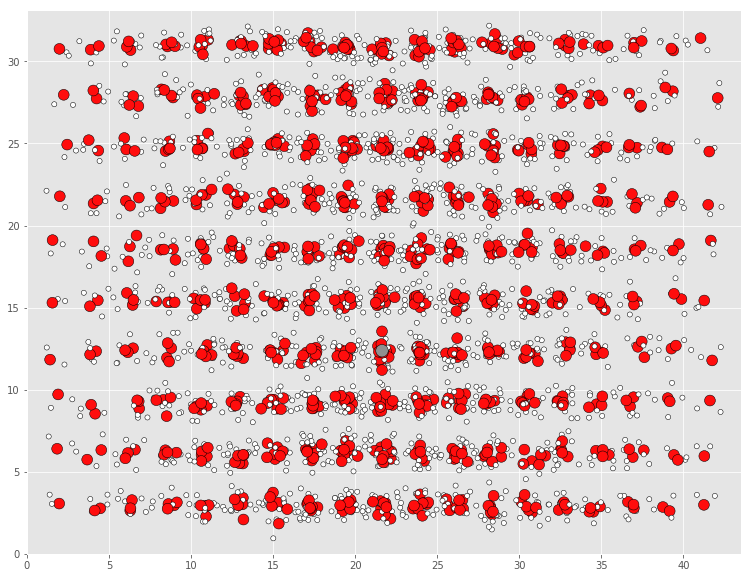

In [42]:
#style.use('dark_background')
style.use('ggplot')
figure(figsize=(18, 10))
plot_atoms(CO2_solvation, radii=0.5, rotation=('90x,45y,0z'))
write("co2_hydration/CO2_solvation.extxyz", CO2_solvation, format = "extxyz")
show()

In [60]:
def reaxff_params_generator(sim_box, job_name, write = False, **kwargs):

    list_of_elements = sorted(list(set(sim_box.get_chemical_symbols())))

    if 'potential' in kwargs.keys():
        potential = kwargs['potential']
    else:
        potential = 'ffield.reax.Fe_O_C_H_combined'
    
    # Default Parameters
    reaxff_params = {
        # Initialization
        "units": "real",
        "atom_style": "charge",
        "velocity": ["all create 300.0 1050027 rot yes dist gaussian"],

        # Forcefield definition
        "pair_style": "reax/c NULL safezone 16",
        "pair_coeff": ['* * ' + '{0} '.format(potential) + ' '.join(list_of_elements)],
        "neighbor": "2.0 bin",
        "neighbor_modify": "delay 10 check yes",

        # Run and Minimization
        "run": "1",
        "timestep": 1,
        "fix": ["all_nve all nve",
                "qeqreax all qeq/reax 1 0.0 10.0 1e-6 reax/c"]
    }
    
    for key in reaxff_params.keys():
        if key in kwargs.keys():
            reaxff_params[key] = kwargs[key]
    
    write_lammps_data(x + ".lammpsdata")
    calc = LAMMPS(parameters=reaxff_params, always_triclinic=True)
    sim_box.set_calculator(calc)
    if write:
        calc.write_lammps_in(lammps_in=sim_path+"{0}.lammpsin".format(job_name),
                             lammps_trj="{0}.lammpstrj".format(job_name),
                             lammps_data="{0}.lammpsdata".format(job_name))

In [8]:
CO2_solvation_potential = 'ffield.reax.Fe_O_C_H_combined'
CO2_solvation_names = ["CO2_solvation_300K"]
CO2_solvation_input = ["{0}.in".format(x) for x in CO2_solvation_names]
CO2_solvation_commands = ["mpiexec lmp_intel_cpu_intelmpi -in {0} -screen none\n".format(x) for x in CO2_solvation_input]
CO2_solvation_source_files = ['$HOME/LAMMPS_Simulation/potentials/{0}'.format(CO2_solvation_potential)]
CO2_solvation_source_files.extend(['$PBS_O_WORKDIR/'+x for x in CO2_solvation_input])


CO2_solvation_list_of_elements = sorted(list(set(CO2_solvation.get_chemical_symbols())))

CO2_solvation_masses = ["{0} {1}".format(x+1, atomic_masses[atomic_numbers[CO2_solvation_list_of_elements[x]]]) for x in range(len(CO2_solvation_list_of_elements))]

CO2_solvation_reaxff_params = {
    # Initialization
    "units": "real",
    "atom_style": "charge",
    "mass": CO2_solvation_masses,
    "velocity": ["all create 300.0 1050027 rot yes dist gaussian"],
    
    # Forcefield definition
    "pair_style": "reax/c NULL safezone 16",
    "pair_coeff": ['* * ' + '{0} '.format(CO2_solvation_potential) + ' '.join(CO2_solvation_list_of_elements)],
    "neighbor": "2.0 bin",
    "neighbor_modify": "delay 10 check yes",
    
    # Run and Minimization
    "run": "100000",
    "timestep": 0.25,
    "fix": ["1 all nvt temp 300.0 300.0 100.0",
            "2 all qeq/reax 1 0.0 10.0 1e-6 reax/c"]
}

CO2_solvation_PBS = PBS_Submitter(job_names=CO2_solvation_names,
                                  job_commands=CO2_solvation_commands,
                                  modules=["mpi", "lammps/11Aug17", "intel-suite/2017"],
                                  walltime="16:00:00",
                                  proc_nodes=1,
                                  proc_cpus=8,
                                  proc_mpiprocs=8,
                                  memory=4,
                                  source_files=CO2_solvation_source_files)
CO2_solvation_PBS.params

{'source_files': [['$HOME/LAMMPS_Simulation/potentials/ffield.reax.Fe_O_C_H_combined',
   '$PBS_O_WORKDIR/CO2_solvation_300K.in']],
 'job_names': ['CO2_solvation_300K'],
 'job_commands': [['mpiexec lmp_intel_cpu_intelmpi -in CO2_solvation_300K.in -screen none\n']],
 'modules': [['mpi', 'lammps/11Aug17', 'intel-suite/2017']],
 'walltime': ['16:00:00'],
 'proc_nodes': [1],
 'proc_cpus': [8],
 'proc_mpiprocs': [8],
 'memory': [4]}

In [9]:
CO2_solvation_calc = LAMMPS(parameters=CO2_solvation_reaxff_params, no_data_file=True, always_triclinic=True)

CO2_solvation.set_calculator(CO2_solvation_calc)

CO2_solvation_calc.atoms = CO2_solvation.copy()
CO2_solvation_calc.prism = Prism(CO2_solvation_calc.atoms.get_cell())

CO2_solvation_calc.write_lammps_in(lammps_in=sim_path+"co2_hydration/CO2_solvation_300K.in",
                                   lammps_trj="CO2_solvation_300K.lammpstrj")

In [56]:
curr_dir = os.getcwd()
os.chdir(sim_path + "co2_hydration")

CO2_solvation_out, CO2_solvation_err = CO2_solvation_PBS.run()

os.chdir(curr_dir)

In [17]:
qstat_monitor(update_frequency=5, jobs_list=CO2_solvation_out)

           JobID        Job Name            User         Runtime          Status           Queue


In [10]:
CO2_solvation_out = ['2147385.cx1']

# Converting solvated CO2 lammpstrj to ase traj

In [ ]:
# Converting lammpstrj to ase traj
CO2_solvation_calc.trajectory_out = Trajectory(sim_path + "co2_hydration/CO2_solvation_300K.traj", 'w')
CO2_solvation_calc.read_lammps_trj(lammps_trj = cx1_out + CO2_solvation_out[0] + r"/CO2_solvation_300K.lammpstrj")
CO2_solvation_calc.trajectory_out.close()

# Try again with 10 CO2 molecules

In [9]:
random.seed(1050027)

ns_remove = random.choice(10, size=10, replace=False)

#CO2_solvation = replace_molecule(H2O_bulk, n_remove, molecule('CO2'))

In [1]:
print('hi')

hi
